In [1]:
import numpy as np
import librosa
import os
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Đặc trưng âm sắc

In [2]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    flux = librosa.onset.onset_strength(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]
    low_energy = librosa.feature.rms(y=y)[0]
    
    mean_spectral_centroid = np.mean(spectral_centroid)
    std_spectral_centroid = np.std(spectral_centroid)
    mean_rolloff = np.mean(rolloff)
    std_rolloff = np.std(rolloff)
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    mean_zero_crossing_rate = np.mean(zero_crossing_rate)
    std_zero_crossing_rate = np.std(zero_crossing_rate)
    mean_low_energy = np.mean(low_energy)
    std_low_energy = np.std(low_energy)
    
    feature_vector = np.array([mean_spectral_centroid, std_spectral_centroid,
                               mean_rolloff, std_rolloff,
                               mean_flux, std_flux,
                               mean_zero_crossing_rate, std_zero_crossing_rate,
                               mean_low_energy, std_low_energy])
    
    return feature_vector


In [3]:
def process_directory(dir_path):
    X = []  # Danh sách để lưu các đặc trưng âm nhạc
    Y = []  # Danh sách để lưu nhãn tương ứng với mỗi bài hát

    # Duyệt qua tất cả các thư mục và tập tin trong dir_path
    for subdir, _, files in os.walk(dir_path):
        files.sort()  # Sắp xếp các file âm nhạc theo thứ tự
        for file in files:
            if file.endswith('.wav'):  # Đảm bảo chỉ xử lý các file âm nhạc có đuôi .wav
                file_path = os.path.join(subdir, file)  # Đường dẫn đầy đủ đến file âm nhạc
                features = extract_features(file_path)  # Trích xuất các đặc trưng từ file âm nhạc
                label = os.path.basename(subdir)  # Nhãn là tên thư mục chứa file âm nhạc
                X.append(features)  # Thêm các đặc trưng vào danh sách X
                Y.append(label)  # Thêm nhãn tương ứng vào danh sách Y

    return np.array(X), np.array(Y)  # Trả về các đặc trưng và nhãn dưới dạng mảng NumPy


In [8]:
DIR = 'VNTM3'
# Load and process data
X, Y = process_directory(DIR)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
print("Extracted features:")
for i, feature_vector in enumerate(X):
    print(f"Feature vector {i+1}: {feature_vector}")


Extracted features:
Feature vector 1: [3.09015759e+03 9.28966038e+02 5.85270628e+03 1.75882861e+03
 1.25178707e+00 1.48205996e+00 1.78378362e-01 7.45637914e-02
 7.06782639e-02 3.43541987e-02]
Feature vector 2: [2.76567763e+03 8.00751985e+02 5.07182766e+03 1.75501619e+03
 1.40071273e+00 1.26336288e+00 1.61671736e-01 5.37674321e-02
 1.22712903e-01 7.38294050e-02]
Feature vector 3: [2.50294187e+03 7.49759248e+02 4.58153063e+03 1.61464119e+03
 1.29087806e+00 1.13622510e+00 1.47270462e-01 5.85106439e-02
 1.00276537e-01 5.92648722e-02]
Feature vector 4: [2.67796967e+03 6.16197869e+02 4.69353829e+03 1.25744725e+03
 1.45817423e+00 1.48890400e+00 1.66326659e-01 5.38550619e-02
 1.35611027e-01 7.89578557e-02]
Feature vector 5: [2.74800051e+03 6.39436646e+02 4.93611182e+03 1.37094231e+03
 1.50915921e+00 1.62391043e+00 1.70113106e-01 5.24878311e-02
 1.23214073e-01 7.49994293e-02]
Feature vector 6: [2.69734584e+03 6.79688793e+02 5.08875256e+03 1.48498660e+03
 1.57418621e+00 1.54517591e+00 1.51788576

Đặc trưng âm sắc 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

In [12]:
from sklearn.model_selection import GridSearchCV
import joblib
knn = KNeighborsClassifier()

params = {
    'n_neighbors': [5, 7, 9, 11],  # Thay đổi số lượng hàng xóm
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

grid_search = GridSearchCV(knn, params, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

print("Best accuracy found on training set: ", grid_search.best_score_)

best_knn = grid_search.best_estimator_
test_accuracy = best_knn.score(X_test, y_test)
print(f"Độ chính xác của model tốt nhất trên tập kiểm tra: {test_accuracy * 100:.2f}%")


Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best accuracy found on training set:  0.8856373311502252
Độ chính xác của model tốt nhất trên tập kiểm tra: 90.93%
Model đã được lưu vào file 'best_knn_model.pkl'.


In [13]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean',weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', weights='distance')

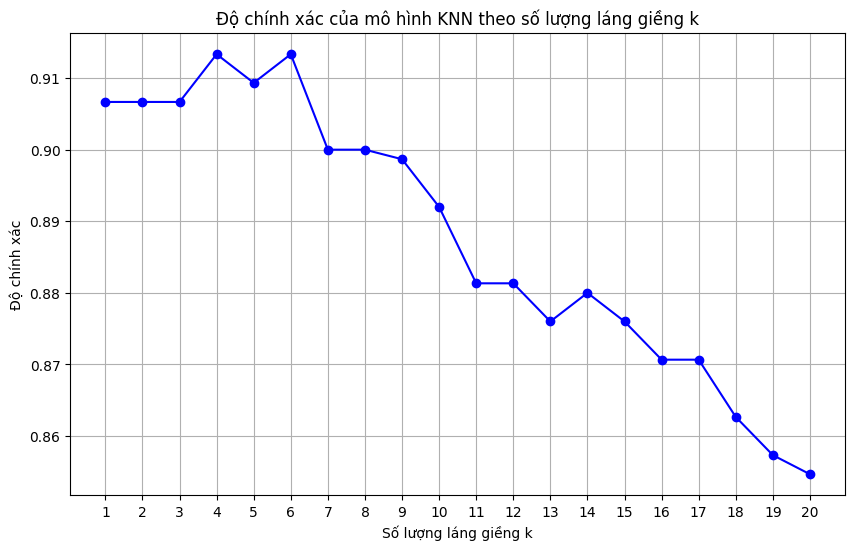

In [15]:
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Độ chính xác của mô hình KNN theo số lượng  k')
plt.xlabel('Số lượng láng giềng k')
plt.ylabel('Độ chính xác')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [16]:
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(scaler, 'tone_scaler.pkl')

['scaler.pkl']

Đặc trưng nhịp điệu - rhythmic

In [22]:
import os
import numpy as np
import pywt
from scipy.signal import filtfilt, resample
import soundfile as sf 
def Rhythmic_features(signal, sampling_rate):
    features2 = []
    # Phân tích tín hiệu thành phần bằng DWT
    coeffs = pywt.wavedec(signal, 'db4', level=3)
    # Áp dụng Envelope Extraction (EE) trên từng thành phần
    for coeff in coeffs:
        # Full Wave Rectification (FWR)
        rectified_signal = np.abs(coeff)
        # Low Pass Filter (LPF)
        alpha = 0.99
        lpf_signal = filtfilt([1-alpha], [1, -alpha], rectified_signal)
        # Downsampling (DS)
        downsampled_signal = resample(lpf_signal, len(lpf_signal)//16)
        # Mean Removal (MR)
        mean_removed_signal = downsampled_signal - np.mean(downsampled_signal)
        # Autocorrelation (AR)
        autocorr = np.correlate(mean_removed_signal, mean_removed_signal, mode='full')
        # Tính các đỉnh cao nhất
        peaks_idx = np.argsort(-autocorr)[:3]
        peak_values = autocorr[peaks_idx]
        # Tính các đặc trưng về nhịp điệu
        if np.sum(autocorr) != 0:
            A1 = peak_values[0] / np.sum(autocorr)
            A2 = peak_values[1] / np.sum(autocorr)
        else:
            A1 = 0
            A2 = 0
        RA = peak_values[1] / peak_values[0]
        # Chu kỳ của các đỉnh
        P1 = 60 * sampling_rate / peaks_idx[0]
        P2 = 60 * sampling_rate / peaks_idx[1]
        # Tổng biên độ của các đỉnh
        SUM = np.sum(peak_values)
        # Tạo vectơ đặc trưng nhịp điệu
        beat_features = [A1, A2, RA, P1, P2, SUM]
        features2.append(beat_features)
    
    return features2

In [23]:
def process_directory(directory):
    X = []
    Y = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                signal, sampling_rate = sf.read(file_path)
                features = Rhythmic_features(signal, sampling_rate)
                label = os.path.basename(subdir)
                X.append(features)
                Y.append(label)
    return X, Y


In [24]:
DIR = 'VNTM3'
X, Y = process_directory(DIR)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)